## SOCRATA QUERY for 311  
Format query by variables.  
By narrowing the query enough, we can avoid paganition in data. 

In [1]:
import requests
import pandas as pd
pd.set_option( "display.max_columns" , None )

### Generate Query URL  
* Time (> 2022)
* Locations (1 mile)
* descriptors (formatted fro SQL query)  

*What other descriptors to use?*

In [3]:

time_start = '2022-01-01'

# Howard Beach
lat = 40.6575627
lon = -73.8409410

radius = 1609 # 1 mile in meters
descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Sewer Backup (Use Comments) (SA)', 'Failure To Retain Water/Improper Drainage- (LL103/89)','Manhole Overflow (Use Comments) (SA1)', 'Snow/Ice'] 

#Convert descriptors to multiple category searches
cats = "({})".format( " ".join( [f"descriptor='{i}' OR" for i in descriptors] )[:-3] )

base_url = f"https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date>='{time_start}' AND within_circle(location, {lat}, {lon}, {radius}) AND {cats}"

print( base_url )


https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date>='2022-01-01' AND within_circle(location, 40.6575627, -73.840941, 1609) AND (descriptor='Street Flooding (SJ)' OR descriptor='Catch Basin Clogged/Flooding (Use Comments) (SC)' OR descriptor='Sewer Backup (Use Comments) (SA)' OR descriptor='Failure To Retain Water/Improper Drainage- (LL103/89)' OR descriptor='Manhole Overflow (Use Comments) (SA1)' OR descriptor='Snow/Ice')


### Send Query

In [4]:
response = requests.get( base_url )

df = pd.DataFrame().from_records( response.json() )

print( "{} rows are found".format( df.shape[0] ) )
df.head()

185 rows are found


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,address_type,city,status,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,closed_date,resolution_description,resolution_action_updated_date,intersection_street_1,intersection_street_2,location_type,landmark
0,56427233,2023-01-03T12:32:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11414,89-19 160 AVENUE,160 AVENUE,89 ST,90 ST,ADDRESS,HOWARD BEACH,Open,10 QUEENS,4140100090,QUEENS,1027822,178682,PHONE,Unspecified,QUEENS,40.657010308906536,-73.84296085288317,"{'latitude': '40.657010308906536', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56433499,2023-01-03T11:25:23.000,DOB,Department of Buildings,Plumbing,Failure To Retain Water/Improper Drainage- (LL...,11414,101-19 158 AVENUE,158 AVENUE,NaN,NaN,ADDRESS,HOWARD BEACH,Open,10 QUEENS,4141620030,QUEENS,1030692,180490,UNKNOWN,Unspecified,QUEENS,40.66195827447803,-73.83260457217446,"{'latitude': '40.66195827447803', 'longitude':...",2023-01-03T11:25:23.000,Your Service Request has been submitted to the...,2023-01-03T00:00:00.000,NaN,NaN,NaN,NaN
2,56421790,2023-01-02T16:17:00.000,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),11414,NaN,NaN,NaN,NaN,INTERSECTION,QUEENS,Open,10 QUEENS,NaN,QUEENS,1024452,181822,PHONE,Unspecified,QUEENS,40.665644845581454,-73.8550880258652,"{'latitude': '40.665644845581454', 'longitude'...",NaN,NaN,NaN,79 STREET,153 AVENUE,NaN,NaN
3,56425946,2023-01-02T16:17:00.000,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),11414,151-44 80 STREET,80 STREET,151 AVE,153 AVE,ADDRESS,HOWARD BEACH,Closed,10 QUEENS,4114267501,QUEENS,1024625,182330,PHONE,Unspecified,QUEENS,40.66703840350512,-73.85446138953739,"{'latitude': '40.66703840350512', 'longitude':...",2023-01-04T13:05:00.000,The Department of Environment Protection inspe...,2023-01-04T13:05:00.000,NaN,NaN,NaN,NaN
4,56416809,2023-01-01T14:05:00.000,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),11414,99-45 164 ROAD,164 ROAD,DEAD END,BEND,ADDRESS,HOWARD BEACH,Closed,10 QUEENS,4142501465,QUEENS,1031401,176646,PHONE,Unspecified,QUEENS,40.65140360972908,-73.83007593767614,"{'latitude': '40.65140360972908', 'longitude':...",2023-01-01T19:15:00.000,The Department of Environmental Protection inv...,2023-01-01T19:15:00.000,NaN,NaN,NaN,NaN


### Generate GeoDataFrame

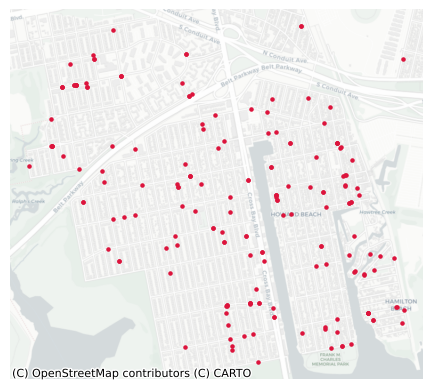

In [14]:
import geopandas as gpd
import contextily as cx

gdf = gpd.GeoDataFrame(
    data = df,
    geometry= gpd.points_from_xy(df['longitude'],df['latitude']),
    crs = 4326
)

ax = gdf.to_crs(epsg=3857).plot( color='crimson' , markersize=5 )
cx.add_basemap(ax , source=cx.providers.CartoDB.Positron )
ax.axis('off');